## BIOS 470/570 Lecture 15

## Last time we covered:
* ### NCBI databases [Gene and nucleotide]
* ### The blast algorithm and web interface
* ### Accessing NCBI databases programmatically
* ### Using the BLAST alignment tool programmatically

## Today we will cover:
* ### Introduction to biological imaging
* ### FIJI/ImageJ
* ### Reading and displaying images in python

In [16]:
import numpy as np
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib import animation, rc

# default colormap, figure size, and font size
plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=(8,8)
plt.rcParams['font.size'] = 24

#for playing video using matplotlib
rc('animation', html='html5')


### The imread function from the iomodule can be used to read images as numpy arrays:

In [68]:
img = io.imread('data/stemCellMovie.tif')

In [54]:
img.shape

(67, 368, 378)

### Here the 67 is the number of timepoints and 368x378 are the dimensions of the image. Let's look at the first image:

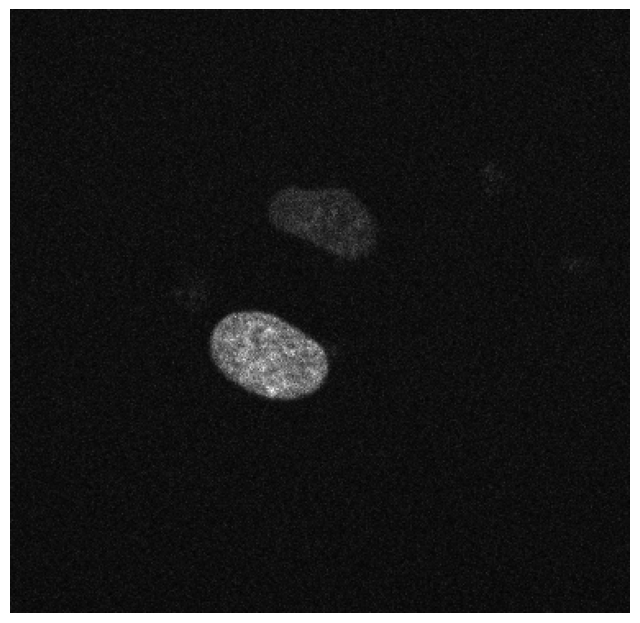

In [55]:
plt.imshow(img[0,:,:]);
plt.axis('off');

### And one near the end:

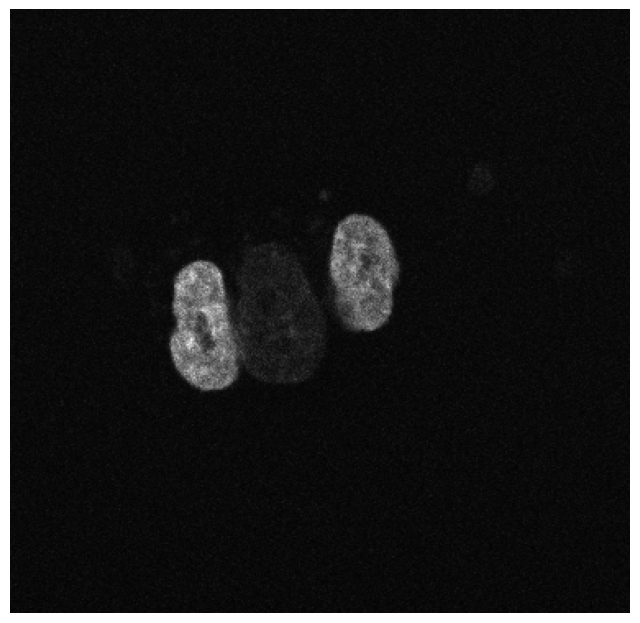

In [56]:
plt.imshow(img[60,:,:]);
plt.axis('off');

### When an image is displayed, the computer must determine a mapping between the pixel values in the image and what is shown on the screen, this is encoded in the lookup table. Let's see what values are in the image:

In [8]:
print(f'{img.min(),img.max()}')

(391, 13622)


### Make a histogram of all values in the whole stack

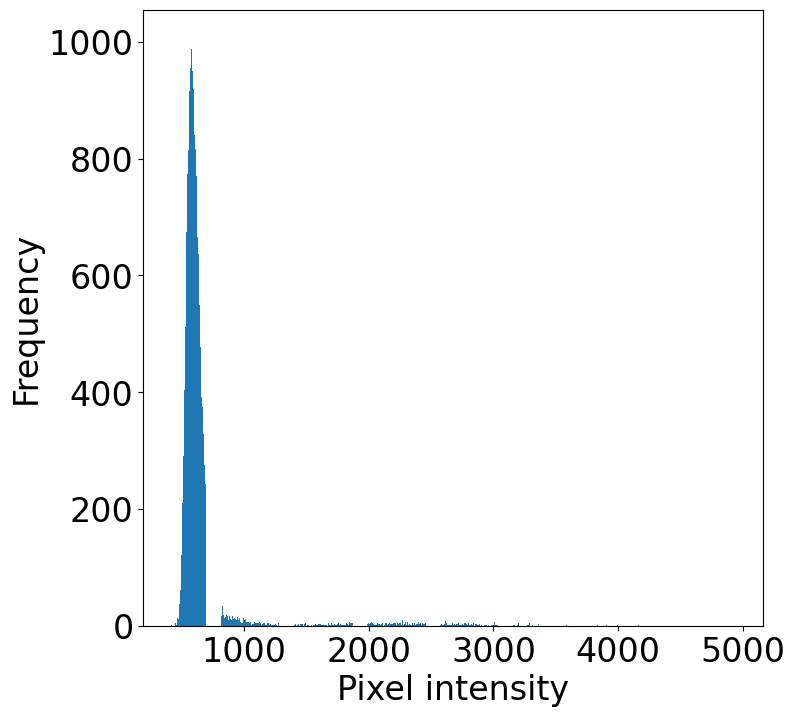

In [24]:
hist = exposure.histogram(img[60,:,:])
plt.bar(hist[1],hist[0]);
plt.ylabel('Frequency')
plt.xlabel('Pixel intensity');


### When we change the lookup table, we change how the image appears while the underlying data remains the same. One simple way to change how the image is displayed is with the vmin and vmax parameters:

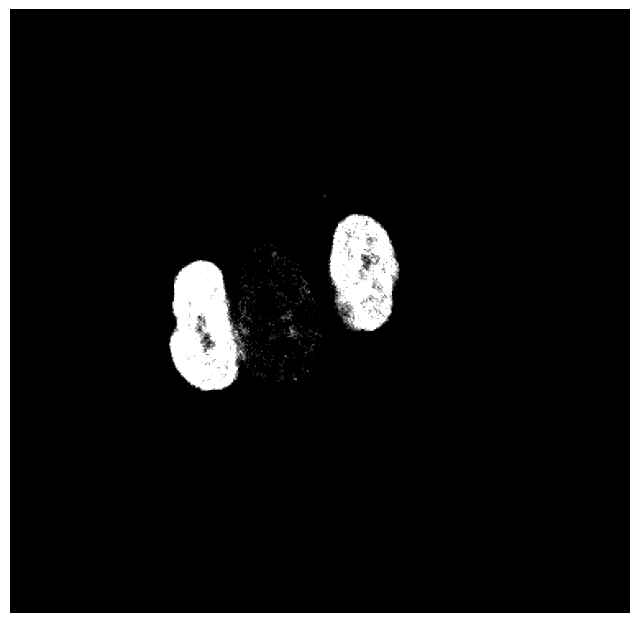

In [60]:
plt.imshow(img[60,:,:],vmin = 1000, vmax = 2000);
plt.axis('off');

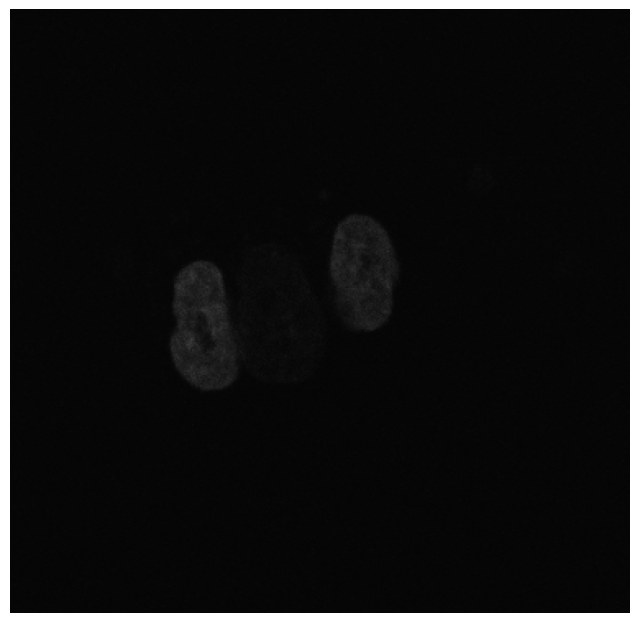

In [70]:
plt.imshow(img[60,:,:],vmin = 100, vmax = 20000);
plt.axis('off');

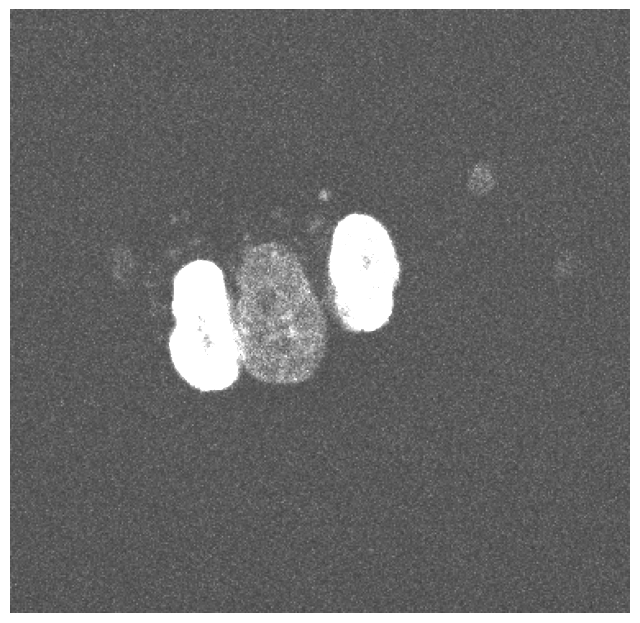

In [71]:
plt.imshow(img[60,:,:],vmin = 100, vmax = 1500);
plt.axis('off');

### One can do this in a more systematic way by looking at percentiles in the image. Here we will use the rescale_intensity function to change the intensity values in the image to cover the full range available for a 16-bit image:

#### First find the percentiles:

In [26]:
Imin,Imax = np.percentile(img,(2,98))
print(f'{Imin,Imax}')

(508.0, 1889.0)


#### Now do the rescale. 

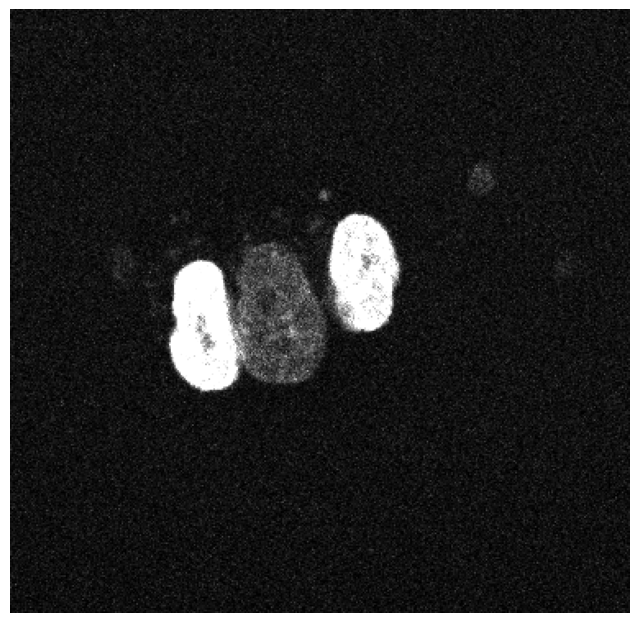

In [27]:
scaled_img60 = exposure.rescale_intensity(img[60,:,:],in_range=(Imin,Imax))
plt.imshow(scaled_img60);
plt.axis('off');

### check that the scaled image covers the full range:

In [13]:
print(f'{scaled_img60.min(),scaled_img60.max()}')

(0, 65535)


### you can use the animation library in matplotlib to play movies or write videos. This requires ffmpeg. Do conda install ffmpeg and you also need to install ffmpeg binary. For example from [here](https://evermeet.cx/ffmpeg/)

RuntimeError: Requested MovieWriter (ffmpeg) not available

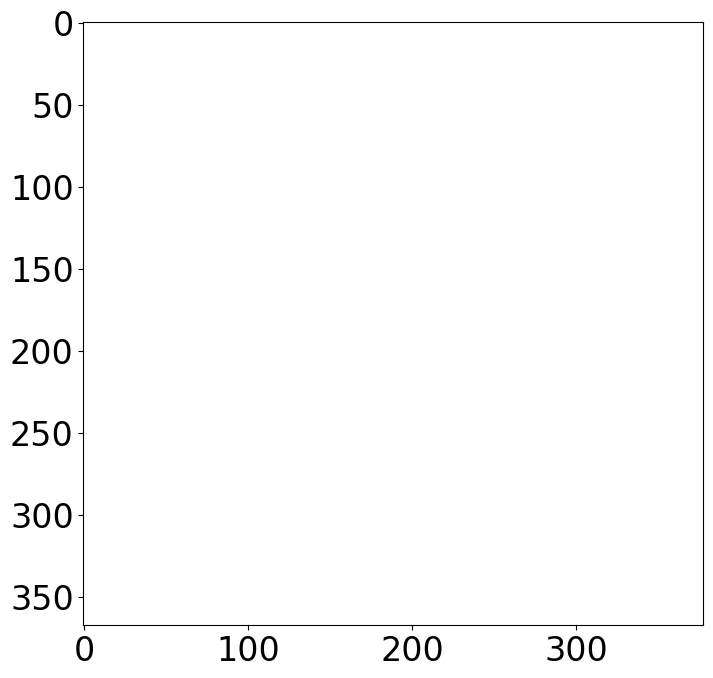

In [31]:
fig, ax = plt.subplots()
ims = []
for i in range(img.shape[0]):
    scaled_img = exposure.rescale_intensity(img[i,:,:],in_range=(Imin,Imax))
    im = ax.imshow(scaled_img, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)
ani

### Sometime we do not want to read the whole image at once because it might take too much memory or too long. imread can use different plugins to do the reading. If you use the tifffile plugin, you can also specify a key which indicates which images to read:

#### Only the first one:

In [32]:
img = io.imread('data/stemCellMovie.tif',plugin="tifffile",key = 0)

In [33]:
img.shape

(368, 378)

#### The 11th one

In [34]:
img = io.imread('data/stemCellMovie.tif',plugin="tifffile",key = 10)

#### The first 30:

In [36]:
img = io.imread('data/stemCellMovie.tif',plugin="tifffile",key = range(30))
img.shape

(30, 368, 378)

#### Now let's look at a different kind of data with multiple z slices and channels, but no timelapse:

In [63]:
img = io.imread('data/230808_Sm4Sox2_BMP20230809_104327 AM_f0020.tif')
img.shape

(5, 1024, 1024, 4)

### The first dimension indicates there are 5 z-slices. Each image is 1024x1024 and there are four channels. It is often useful to visualize the data but taking a maximum intensity over z (i.e. for each pixel in each channel only take the brightest value over the whole z-stack). Once the image is loaded, this can be done easily:

In [64]:
img_max = np.max(img,axis=0)

### Now there is only 1 z plane (i.e. the max of all the others)

In [65]:
img_max.shape

(1024, 1024, 4)

### Let's see if we can look at three of those channels as an RGB image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


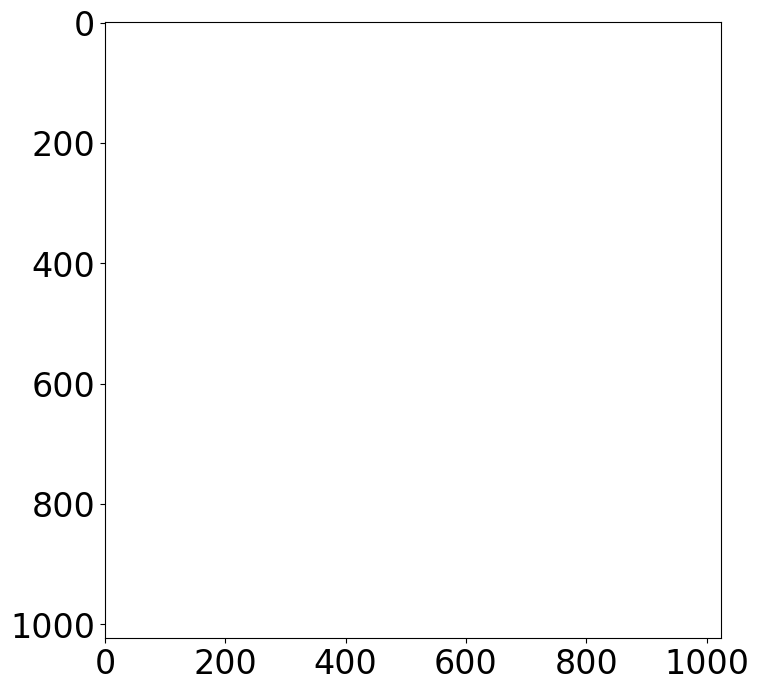

In [66]:
plt.imshow(img_max[:,:,[0, 2, 3]])

### That didn't work well. The reason is that the matplotlib RGB image display only handles 8 bit images. It automatically cut off all values above 255. Instead, let's rescale each channel to fit inside the 8 bit range.

#### The maps the intensity values from the 1st to the 99th percentile in each channel to the range (0,255)

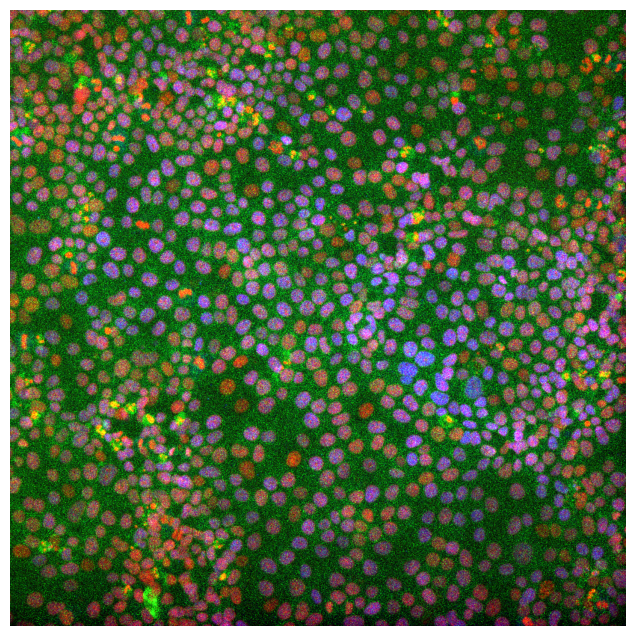

In [51]:
img_max_scaled = img_max
for cc in range(4):
    Imin, Imax = np.percentile(img_max[:,:,cc],(1, 99))
    img_max_scaled[:,:,cc] = exposure.rescale_intensity(img_max[:,:,cc],in_range=(Imin, Imax), out_range=(0,255))

plt.imshow(img_max_scaled[:,:,[0,2,3]])
plt.axis('off');